# Polars
> DataFrames increíblemente rápidos en Rust, Python y Node.js.

- toc: true 
- badges: false
- comments: true
- categories: [DataFrames, Rust, Distribution]
- image: images/python.png

# Introducción

[Polars](https://github.com/pola-rs/polars) es una librería de DataFrames increíblemente rápida implementada en [Rust](https://github.com/rust-lang/rust) utilizando [Arrow Columnar Format](https://arrow.apache.org/docs/format/Columnar.html) de Apache como modelo de memoria.


* Lazy | eager execution
* Multi-threaded
* SIMD (Single Instruction, Multiple Data)
* Query optimization
* Powerful expression API
* Rust | Python | ...

Esta sección tiene como objetivos presentarle *Polars* a través de ejemplos y comparándolo con otras soluciones.

> **Nota**: Si usted no esta familiarizado con la manipulación de datos en Python, se recomienda partir leyendo sobre la librería de [Pandas](https://pandas.pydata.org/docs/). También, se deja como referencia el curso de [Manipulación de Datos](https://gitlab.com/FAAM/python_data_manipulation).

# Primeros Pasos

## Instalación

Para instalar **Polars**, necesitará usar la línea de comando. Si ha instalado Anaconda, puede usar:

```
conda install -c conda-forge polars
```

De lo contrario, puede instalar con pip:


```
pip install polars
```

> **Nota**: No interactuarás directamente con **RISE**. En su lugar, podrá acceder a él a través de Jupyter Notebooks.


# Rendimiento
*Polars* es muy rápido y, de hecho, es una de las mejores soluciones disponibles. Tomemos como referencia [db-benchmark](https://h2oai.github.io/db-benchmark/) de h2oai. Esta página tiene como objetivo comparar varias herramientas similares a bases de datos populares en la ciencia de datos de código abierto. Se ejecuta regularmente con las últimas versiones de estos paquetes y se actualiza automáticamente.

También se incluye la sintaxis que se cronometra junto con el tiempo. De esta manera, puede ver de inmediato si está realizando estas tareas o no, y si las diferencias de tiempo le importan o no. Una diferencia de 10x puede ser irrelevante si eso es solo 1s frente a 0,1s en el tamaño de sus datos.

A modo de ejemplo, veamos el *performances* de distintas librerías para ejecutar un *groupby* sobre un dataset de tamaño **50 gb**. Se observa que *Polars* supera a librerías espacializadas en distribución de Datframes como *Spark*(143 segundos vs 568 segundos). Por otro lado, librerías conocidas en Python como *Pandas* o *Dask* se tiene el problema de **out of memory**.


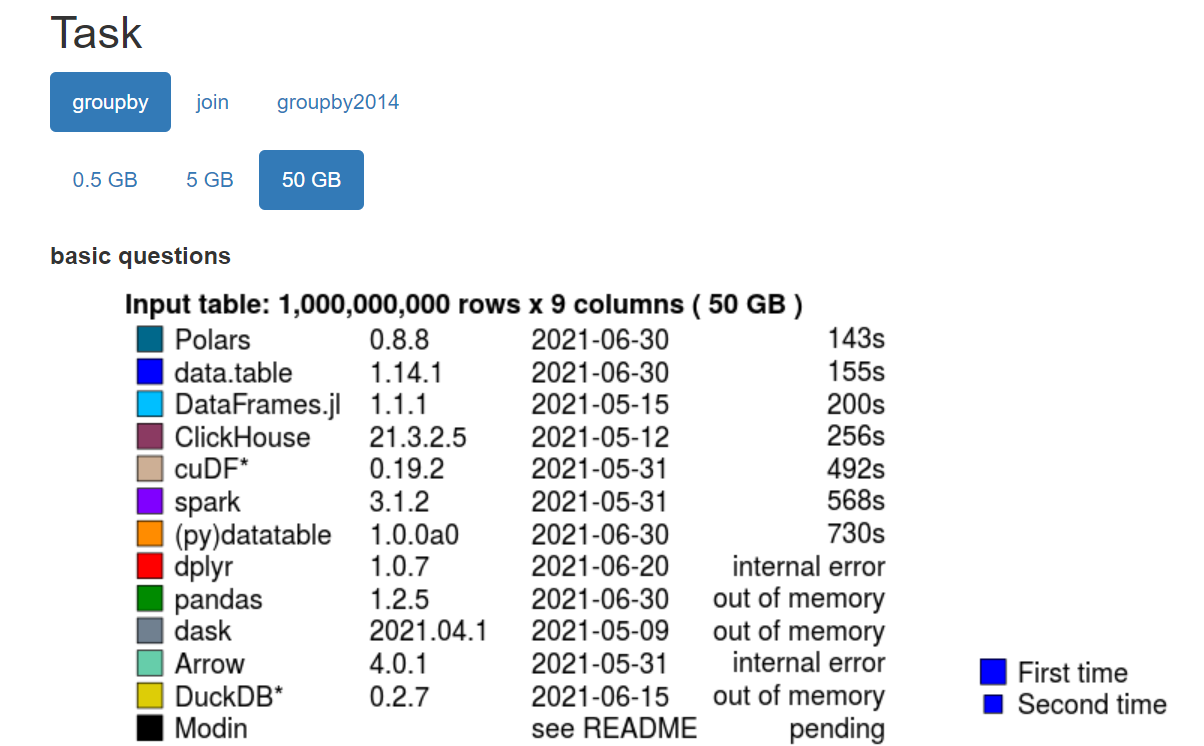